# Micrograd from Scratch with Andrej Karpathy


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's define a function f(x) where f(x) = 3x^2 - 4x + 5

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

f(3.0)  # Example evaluation of the function

20.0

Now lets create an array of x values and compute the corresponding f(x) values and plot them to visualize the function.

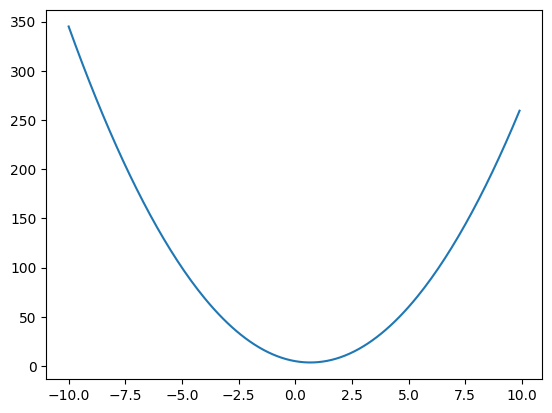

In [3]:
xs = np.arange(-10, 10, 0.1)
ys = f(xs)
plt.plot(xs, ys)

Let's understand what the derivative of this function means. The derivative f'(x) gives us the slope of the tangent line to the curve at any point x. It tells us how fast the function is changing at that point.

In [4]:
h = 1e-5  # A small value for numerical differentiation
x = 2/3
(f(x + h) - f(x)) / h

3.0000002482211127e-05

Let's look at a bit more complex case.
The output variable 'd' below is a function of three scalars.

In [5]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [6]:
h = 1e-4

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('Slope: ', (d2 - d1) / h)

d1:  4.0
d2:  3.999699999999999
Slope:  -3.000000000010772


The slope, given above by (d2 - d1)/h is how much the function increased when we increased x by a small amount h. This is the essence of numerical differentiation.

In [7]:
h = 1e-4

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('Slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.0002
Slope:  2.0000000000042206


In [8]:
h = 1e-4

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('Slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.0001
Slope:  0.9999999999976694


## Now let's start diving into the neural network part of the problem.

In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # Gradient represents the derivative of this value with respect to some loss
        # It is initialized to 0 and will be updated during backpropagation
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value that represents the addition of this and other
        # The new Value will have this and other as its parents (_children)
        # and the operation as '+'
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        # This is the right addition, which allows us to write 3 + a instead of a + 3
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value that represents the multiplication of this and other
        # The new Value will have this and other as its parents (_children)
        # and the operation as '*'
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        # This is the right multiplication, which allows us to write 3 * a instead of a * 3
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Exponent must be an integer or float"
        # Create a new Value that represents the power operation
        out = Value(self.data ** other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other if isinstance(other, Value) else Value(-other))
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), _children=(self,), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out

    def tanh(self):
        # out = Value(np.tanh(self.data), _children=(self,), _op='tanh')
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        # Initialize the gradient of this value to 1
        self.grad = 1.0
        
        # Let's add Topological Sort to ensure we process nodes in the correct order, that all the parents of a node are processed before the node itself.
        # Create a stack for topological sorting
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        # Backward pass through the topologically sorted nodes
        for v in reversed(topo):
            v._backward()

a = Value(2.0)
a

Value(data=2.0)

Value class is a simple wrapper around a scalar value. It allows us to create objects that can hold a single scalar value.
Python internally uses the `__repr__` method to define how an object is represented as a string. This is useful for debugging and logging purposes.

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    # Build the graph
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # Create node label
        label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad)
        dot.node(name=uid, label=label, shape='record')
        
        if n._op:
            # Add operation node
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


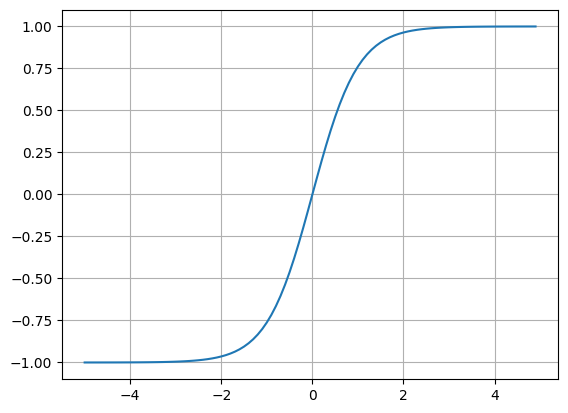

In [11]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1))); plt.grid()

## Now let's create a simple neuron

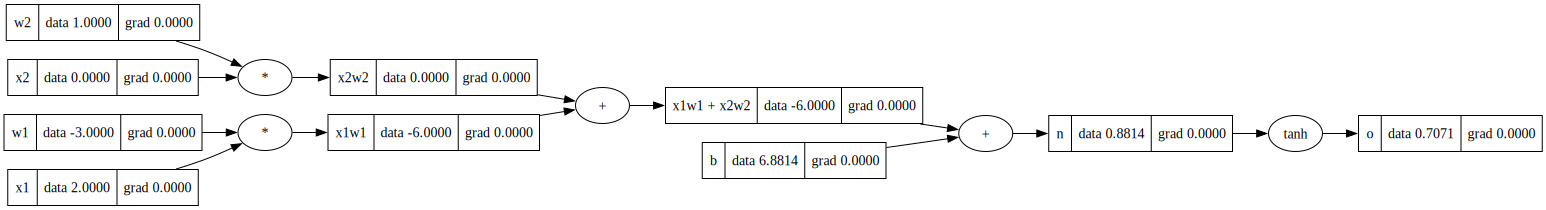

In [12]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')  # This is tanh(2.0) + 3.0

# Neuron output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

## Doing backpropagation

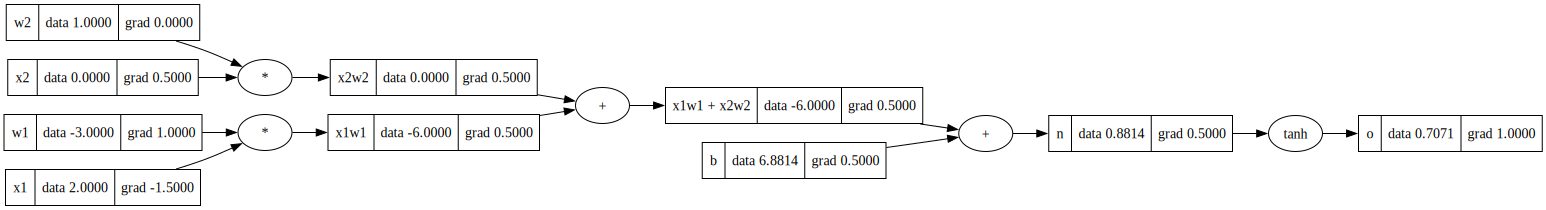

In [13]:
o.backward() # Call the backward function for each node in topological order
draw_dot(o)


Let's break down tanh function into its components:

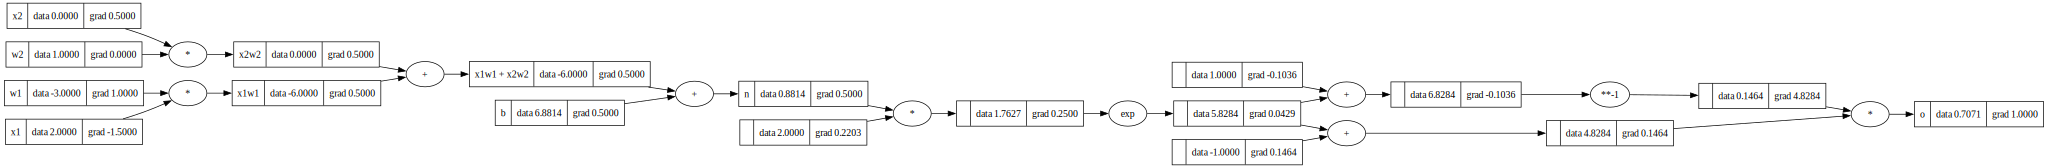

In [14]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')  # This is tanh(2.0) + 3.0

# Neuron output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# -----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----

o.label = 'o'
o.backward() # Call the backward function for each node in topological order
draw_dot(o)

## Replicatinmg the same using pytorch

In [15]:
import torch

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())

o.backward()  # Compute gradients

print('---')
print('x1.grad:', x1.grad.item())
print('x2.grad:', x2.grad.item())
print('w1.grad:', w1.grad.item())
print('w2.grad:', w2.grad.item())
print('b.grad:', b.grad.item())


0.7071067094802856
---
x1.grad: -1.5000003576278687
x2.grad: 0.5000001192092896
w1.grad: 1.000000238418579
w2.grad: 0.0
b.grad: 0.5000001192092896
